## Config

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from common import *
import competitions.udacity as comp;

/home/bfortuner/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
_, ids_ = comp.make_autti_meta_file()
meta = comp.load_metadata('autti')
TRAIN_PATH = meta['img_dir']
TEST_PATH = comp.PATHS['datasets']['inputs']['tst_jpg']
fold = comp.helpers.make_fold(meta, 'autti_15', .15)

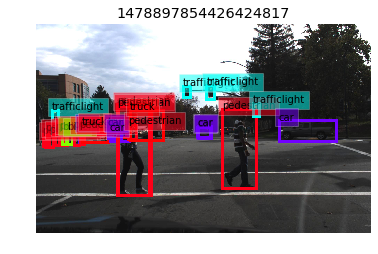

In [3]:
# View images
idx = random.randint(0, len(fold[c.TRAIN]))
img_id = fold[c.TRAIN][idx]
img = utils.imgs.load_img_as_arr(os.path.join(TRAIN_PATH, img_id+c.JPG_EXT))
bboxes = meta['imgs'][img_id]['bboxes']
title = meta['imgs'][img_id]['img_id']
utils.imgs.plot_img_w_bboxes(img, bboxes, comp.LABEL_TO_IDX, title)

In [4]:
HARDWARE_CONFIG = {
    'hostname': cfg.HOSTNAME,
    'random_seed': 3,
    'gpu_device':0
}
torch.cuda.set_device(HARDWARE_CONFIG['gpu_device'])
torch.set_default_tensor_type('torch.cuda.FloatTensor')
cudnn.benchmark = True

DATA_CONFIG = {
    'img_rescale': 300,
    'dset_fold': '2007',
    'n_classes': len(comp.LABEL_NAMES) + 1, #extra background?
    'img_mean': (104, 117, 123)
}

TRAIN_CONFIG = {
    'initial_lr': 1e-4,
    'weight_decay': 5e-4,
    'momentum': 0.9,
    'n_epochs': 100, #120K iters
    'n_cycles': 9,
    'early_stop_metric': metric.Loss().name,
    'max_patience': 20,
    'batch_size': 16,
    'threshold': 0.5,
    'save_weights_cadence': 1, #every epoch
    'lr_schedule': {50: 1e-4, 90: 1e-5}
}

OTHER_CONFIG = {}

TRANSFORMS = {
    c.TRAIN: torchsample.transforms.Compose([
        data_aug.SSDAugmentation(DATA_CONFIG['img_rescale'], 
                                 DATA_CONFIG['img_mean'])
    ]),
    c.VAL: torchsample.transforms.Compose([
        data_aug.SSDBaseAugmentation(DATA_CONFIG['img_rescale'], 
                                     DATA_CONFIG['img_mean'])
    ]),
    c.TEST: torchsample.transforms.Compose([
        data_aug.SSDBaseAugmentation(DATA_CONFIG['img_rescale'], 
                                     DATA_CONFIG['img_mean'])
    ]),
    c.TARGET: torchsample.transforms.Compose([
        data_aug.BBoxTransform(comp.LABEL_TO_IDX)
    ]),
}

## Data

In [5]:
SAMPLE = 10000000
trn_fpaths = data_folds.get_fpaths_from_fold(fold, c.TRAIN, TRAIN_PATH,
                                             postfix=c.INPUT_POSTFIX)[:SAMPLE]
val_fpaths = data_folds.get_fpaths_from_fold(fold, c.VAL, TRAIN_PATH,
                                             postfix=c.INPUT_POSTFIX)[:SAMPLE]
tst_fpaths = data_folds.get_fpaths_from_fold(fold, c.TEST, TEST_PATH, postfix=c.JPG_EXT)

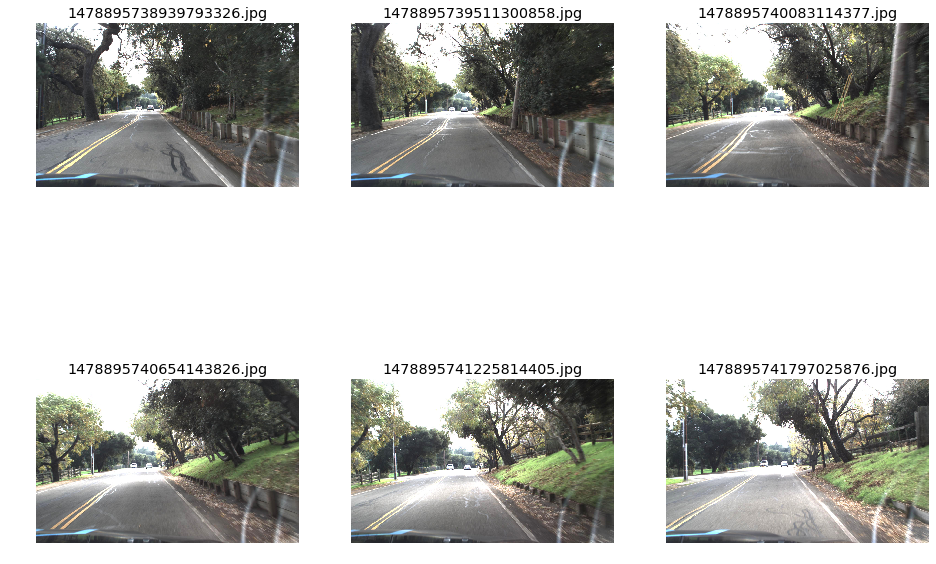

In [6]:
utils.imgs.plot_samples_from_dir(TRAIN_PATH, shuffle=True)

In [7]:
trn_dataset = datasets.datasets.ObjDetectDataset(TRAIN_PATH, fold[c.TRAIN][:SAMPLE], meta, 
                                                 transform=TRANSFORMS[c.TRAIN], 
                                                 target_transform=TRANSFORMS[c.TARGET])
val_dataset = datasets.datasets.ObjDetectDataset(TRAIN_PATH, fold[c.VAL][:SAMPLE], meta, 
                                                 transform=TRANSFORMS[c.VAL], 
                                                 target_transform=TRANSFORMS[c.TARGET])
tst_dataset = datasets.datasets.ObjDetectDataset(TRAIN_PATH, fold[c.TEST], meta, 
                                                 transform=TRANSFORMS[c.TEST], 
                                                 target_transform=TRANSFORMS[c.TARGET])
trn_loader = torch.utils.data.DataLoader(trn_dataset, TRAIN_CONFIG['batch_size'], 
                                         shuffle=True, num_workers=4, pin_memory=True,
                                         collate_fn=data_loaders.detection_collate)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, 
                                         shuffle=False, num_workers=1, pin_memory=True,
                                         collate_fn=data_loaders.detection_collate)
tst_loader = torch.utils.data.DataLoader(tst_dataset, batch_size=1, 
                                         shuffle=False, num_workers=1, pin_memory=True,
                                         collate_fn=data_loaders.detection_collate)

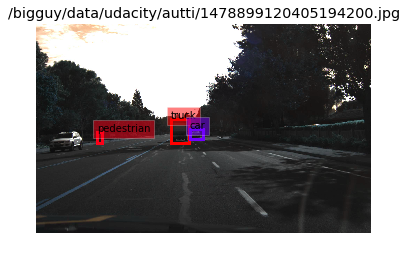

In [8]:
idx = random.randint(0, len(trn_dataset))
utils.imgs.plot_img_w_bboxes(trn_dataset.get_image(idx), 
                             trn_dataset.get_bboxes(idx),
                             comp.LABEL_TO_IDX,
                             trn_dataset.get_fpath(idx))

In [9]:
from models.ssd import ssd
from models.ssd.multibox_loss import MultiBoxLoss
from models.ssd.detection import Detect

model = ssd.build_ssd('train', DATA_CONFIG['img_rescale'], 
                     DATA_CONFIG['n_classes'])
vgg_weights_fpath = torch.load(os.path.join(
    cfg.PATHS['project'], 'pretrained', 
    'vgg16_reducedfc.pth'))
model.vgg.load_state_dict(vgg_weights_fpath)
model = model.cuda()

model.extras.apply(models.utils.xavier)
model.loc.apply(models.utils.xavier)
model.conf.apply(models.utils.xavier)

optimizer = optim.SGD(model.parameters(), lr=TRAIN_CONFIG['initial_lr'],
                      momentum=TRAIN_CONFIG['momentum'], 
                      weight_decay=TRAIN_CONFIG['weight_decay'])

criterion = MultiBoxLoss(
    DATA_CONFIG['n_classes'], 0.5, True, 
    0, True, 3, 0.5, False, True)

lr_adjuster = learning_rates.ScheduledLR(
    TRAIN_CONFIG['initial_lr'], 'epoch', 
    TRAIN_CONFIG['lr_schedule'])

detect = Detect(DATA_CONFIG['n_classes'], bkg_label=0,
                top_k=200, conf_thresh=0.01, nms_thresh=0.45)

In [10]:
cfg.LABEL_NAMES

('truck', 'biker', 'trafficlight', 'car', 'pedestrian')

In [ ]:
# Load pretrained network
model = ssd.build_ssd('train', DATA_CONFIG['img_rescale'], 
                     DATA_CONFIG['n_classes'])
model.load_weights(os.path.join('/bigguy/data/pascalvoc/pretrained', 'ssd300_mAP_77.43_v2.pth'))

In [11]:
trainer = training.trainers.SSDTrainer(
    criterion, criterion, optimizer, lr_adjuster,
    comp.IDX_TO_LABEL, detect)

In [12]:
img, targ, dims, idx = next(iter(val_loader))
pred = predictions.bboxes.predict(model, img, dims, detect, 0.6, DATA_CONFIG['n_classes'])

In [34]:
img,targ,dims,idx = next(iter(trn_loader))

In [35]:
out = model(Variable(img.cuda()))

In [36]:
out[0].size(), out[1][:2], out[2].size()

(torch.Size([16, 8732, 4]), Variable containing:
 ( 0  ,.,.) = 
   2.7312e-01  2.6345e-01 -6.9720e-01 -9.1642e-01 -8.3913e-03  1.2437e-01
  -2.5167e-01  5.2462e-01  6.8915e-01  9.6520e-01 -7.3392e-01  6.4897e-01
   8.2226e-01  3.9777e-02  5.9389e-01 -1.2920e-01 -1.3490e+00 -1.7952e-01
                                    ⋮                                    
   2.4485e-03  8.4336e-03 -6.6231e-03 -6.2041e-03  1.4475e-02 -8.6954e-04
   2.1459e-02 -1.0118e-02 -1.3836e-03  2.4670e-03 -4.2896e-03  1.0415e-02
   2.9300e-03 -5.6120e-03  1.2341e-03  6.4050e-03  5.3288e-03  1.0091e-02
 
 ( 1  ,.,.) = 
   2.6172e-01 -2.0308e-01 -4.9316e-01 -4.2498e-01 -4.3971e-01 -2.5781e-01
   3.4539e-01  1.0974e-01 -1.2882e-01  1.0836e+00 -1.2127e+00 -3.6815e-01
   7.4322e-01  6.3290e-01 -8.4507e-01  1.4567e+00  5.1265e-01 -2.3999e-02
                                    ⋮                                    
   2.8431e-03  1.3411e-02 -7.5379e-03 -9.0376e-03  1.2415e-02  1.9282e-03
   2.0568e-02 -9.4278e-03 -3.48

In [37]:
preds = predictions.bboxes.get_predictions(model, val_loader, detect, 0.01, DATA_CONFIG['n_classes'])
targs = {id_: meta['imgs'][id_] for id_ in val_loader.dataset.img_ids}

Process Process-10:
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/bfortuner/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/bfortuner/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bfortuner/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/home/bfortuner/anaconda3/lib/python3.6/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/home/bfortuner/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/bfortuner/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/bfortuner/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, re

KeyboardInterrupt: 

In [ ]:
label_level_metrics = metrics.bboxes.get_bb_label_level_metrics(preds, targs, comp.LABEL_NAMES, overlap_thresh=0.5)

In [ ]:
metrics.bboxes.plot_label_level_metric(label_level_metrics, 'ap')
metrics.bboxes.plot_label_level_metric(label_level_metrics, 'iou')
metrics.bboxes.plot_label_level_metric(label_level_metrics, 'total_gt_bbs')
df = metrics.bboxes.get_label_level_bb_metrics(label_level_metrics)
df

## Train

In [ ]:
# Load existing weights (optional)
experiment_name = 'SSD-SGD-ScheduledLR-img300-lr0.001-wd0.0005-bs16-fold1-idBED91'
epoch = 87
exp_utils.load_weights_by_exp_and_epoch(model, experiment_name, epoch)

In [13]:
# Experiment config
NEW_EXP_NAME = ''
RESUME_EXP_NAME = None#'SSD-SGD-ScheduledLR-img300-lr0.001-wd0.0005-bs16-fold1-idBED91'
if not RESUME_EXP_NAME:
    EXP_NAME_ARGS = [utils.general.get_class_name(model),
                    utils.general.get_class_name(optimizer), 
                    utils.general.get_class_name(lr_adjuster),
                    'img'+str(DATA_CONFIG['img_rescale']),
                    'lr'+str(TRAIN_CONFIG['initial_lr']),
                    'wd'+str(TRAIN_CONFIG['weight_decay']),
                    'bs'+str(TRAIN_CONFIG['batch_size']),
                    str(DATA_CONFIG['dset_fold'])]
    EXPERIMENT_NAME = exp_utils.generate_display_name(NEW_EXP_NAME, EXP_NAME_ARGS)
    METRICS = [metric.Loss()]#, metric.Accuracy(), metric.F2Score()]
    AUX_METRICS = [metric.AuxiliaryMetric('LearningRate', 'lr'), 
                   metric.AuxiliaryMetric('SystemMemory', 'mb')]
    VISUALIZERS = [Viz(EXPERIMENT_NAME)]

    EXP_CONFIG = {
        'name': EXPERIMENT_NAME,
        'parent_dir': cfg.PATHS['experiments'],
        'metrics': METRICS,
        'aux_metrics': AUX_METRICS,
        'visualizers': VISUALIZERS,
        'data': DATA_CONFIG,
        'training': TRAIN_CONFIG,
        'other': OTHER_CONFIG,
        'transforms': TRANSFORMS[c.TRAIN],
        'hardware': HARDWARE_CONFIG,
        'model': model,
        'optimizer': optimizer,
        'lr_adjuster': lr_adjuster,
        'criterion': criterion
    }

In [ ]:
# Resume experiment
exp = Experiment(RESUME_EXP_NAME, cfg.PATHS['experiments'])
exp.resume(verbose=True)
trainer = training.trainers.SSDTrainer(
    criterion, criterion, optimizer, lr_adjuster,
    cfg.IDX_TO_LABEL, detect)

In [14]:
# Create new experiment
exp = Experiment(EXP_CONFIG['name'], cfg.PATHS['experiments'])
exp.init(EXP_CONFIG)
print(exp.name)

SSD-SGD-ScheduledLR-img300-lr0.0001-wd0.0005-bs16-2007-idCB630


In [ ]:
exp.train(trainer, trn_loader, val_loader)

/home/bfortuner/anaconda3/lib/python3.6/site-packages/torch/autograd/_functions/tensor.py:450: UserWarning: mask is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return tensor.masked_fill_(mask, value)


iter 10 || Loss: 18.2035
iter 20 || Loss: 13.4482
iter 30 || Loss: 11.0543
iter 40 || Loss: 9.7646
iter 50 || Loss: 9.8245
iter 60 || Loss: 8.7705
iter 70 || Loss: 9.0699
iter 80 || Loss: 9.0361
iter 90 || Loss: 8.1478
iter 100 || Loss: 7.6621
iter 110 || Loss: 6.9162
iter 120 || Loss: 7.6436
iter 130 || Loss: 6.6542
iter 140 || Loss: 6.9766
iter 150 || Loss: 7.9766
iter 160 || Loss: 6.6052
iter 170 || Loss: 6.6342
iter 180 || Loss: 6.8931
iter 190 || Loss: 6.6329


## Predict

In [ ]:
# Load model from exp epoch
exp.load_model_state(epoch=10)
model = exp.model

In [ ]:
preds = trainer.get_predictions(model, val_loader, thresh=0.6)

In [ ]:
img, targs, dims, idx = next(iter(val_loader))
bboxes = trainer.predict(model, img, dims, thresh=0.6)

In [ ]:
idx = random.randint(0,len(preds))
img_arr = utils.imgs.load_img_as_arr(os.path.join(TRAIN_PATH, preds[idx]['img_id']+c.JPG_EXT))
utils.imgs.plot_img_w_bboxes(img_arr, preds[idx]['bboxes'], title=preds[idx]['img_id'])

In [ ]:
pred_utils.save_obj_detect_pred('ssd', preds, None, 0.6, c.VAL)

In [ ]:
rec, prec, ap = voc_eval(
   filename, annopath, imgsetpath.format(set_type), cls, cachedir,
   ovthresh=0.5, use_07_metric=use_07_metric)
aps += [ap]
print('AP for {} = {:.4f}'.format(cls, ap))

In [ ]:
# OR load custom model weights
exp_name = RESUME_EXP_NAME
w_path = os.path.join(cfg.PATHS['experiments'], exp_name, 'weights', 'weights-30.th')
models.utils.load_weights(model, w_path)

In [ ]:
%time val_probs = predictions.get_probabilities(model, val_loader)

In [ ]:
pred_fpath = predictions.get_prediction_fpath(basename='my_exp', dset=c.VAL)
_ = predictions.save_or_append_pred_to_file(pred_fpath, val_probs)

In [ ]:
thresh = TRAIN_CONFIG['threshold']
acc = metric_utils.get_accuracy(val_probs > thresh, val_targs)
f2 = metric_utils.get_metric_in_blocks(val_probs > thresh, val_targs, 
                                       1000, metric_utils.get_f2_score)
loss = metric_utils.get_cross_entropy_loss(val_probs, val_targs)
print("Acc",acc,"F2",f2,"BCE",loss)
utils.imgs.plot_sample_preds(val_fpaths, val_probs > 0.5, val_targs, 
                             dogscats.LABEL_NAMES)

In [ ]:
%time tst_probs = predictions.get_probabilities(model, tst_loader)

In [ ]:
pred_fpath = predictions.get_prediction_fpath(basename='my_exp', dset=c.TEST)
_ = predictions.save_or_append_pred_to_file(pred_fpath, tst_probs)
tst_probs = predictions.load_pred(pred_fpath, numpy=True)
utils.imgs.plot_sample_preds(tst_fpaths, tst_probs > thresh, 
                             None, dogscats.LABEL_NAMES)

## Ensemble

In [ ]:
member_fpaths = predictions.list_local_preds(dset=c.TEST, fnames_only=False)
member_fpaths

In [ ]:
ens_fpath = ensembles.get_ensemble_fpath(basename='my_exp', dset=c.TEST)
_ = ensembles.ens_prediction_files(
    ens_fpath, member_fpaths, block_size=1000, method=c.MEAN)
ens_probs = predictions.load_pred(ens_fpath, numpy=True)

## Submit

In [ ]:
tst_probs = predictions.load_pred(pred_fpath, numpy=True)

In [ ]:
sub_fpath = submissions.get_sub_path_from_pred_path(pred_fpath)
fnames = utils.files.get_fnames_from_fpaths(tst_fpaths)
sub_ids = [f.split('.')[0] for f in fnames]
tst_probs = np.clip(tst_probs, .005, .995) #good for BCE problems
submissions.make_preds_submission(sub_fpath, sub_ids, 
                                  np.expand_dims(tst_probs[:,1],1), 
                                  dogscats.SUB_HEADER)

In [ ]:
# https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
# Public Leaderboard .0566, Top 8%
# kg submit -m 'my sub' -c dogs-vs-cats-redux-kernels-edition -v -u USERNAME -p PASSWORD planet_tst.csv
FileLink(sub_fpath)

## Evaluate

In [ ]:
# Review Experiment
exp_name = 'BaselineSimpleResnet-Adam-ScheduledLR-img256-lr0.001-wd0.0005-bs64-fold4K-id84E8D'
exp = Experiment(exp_name, cfg.PATHS['experiments'])
exp.review(verbose=False)
exp.history.plot()

In [ ]:
# Load Pred
fname = 'my_exp_val.bc'
thresh = TRAIN_CONFIG['threshold']
probs = predictions.load_pred(os.path.join(cfg.PATHS['predictions'], fname))
preds = predictions.get_predictions(probs, thresh)

In [ ]:
# View preds, probs, and targets
eval_df = evaluate.get_evaluate_df(preds, probs, val_targs, 
                                   val_fpaths, dogscats.LABEL_NAMES)
eval_df[:5]

In [ ]:
# View preds by label
LABEL = 'dog'
dog_preds_by_targ = evaluate.get_preds_by_target_label(
    eval_df, LABEL, condensed=False)
dog_preds_by_pred = evaluate.get_preds_by_predicted_label(
    eval_df, LABEL, condensed=False)
dog_preds_by_targ[:5]

In [ ]:
# View preds by probability

# Confident dogs and right (TP)
confident_dogs_tp = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 1, p_min=0.9, p_max=1.0)
# Confident dogs and wrong (FP)
confident_dogs_fp = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 0, p_min=0.9, p_max=1.0)
# Unconfident dogs and right (TN)
unconfident_dogs_tn = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 0, p_min=0.0, p_max=0.1)
# Unconfident dogs and wrong (FN)
unconfident_dogs_fn = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 1, p_min=0.0, p_max=0.1)

# Annotation errors?
evaluate.plot_predictions(unconfident_dogs_fn, dogscats.LABEL_NAMES)
unconfident_dogs_fn

In [ ]:
# View predictions and probabilities
evaluate.plot_predictions(eval_df, dogscats.LABEL_NAMES)

In [ ]:
# Confusion Matrix
evaluate.plot_label_level_cms(eval_df, dogscats.LABEL_NAMES)

In [ ]:
# Plot ROC Curve
evaluate.plot_roc_curve(np.array(probs), val_targs)